# Generative Adversarial Networks (GANs): Fundamentals

## Introduction

Generative Adversarial Networks (GANs), introduced by Goodfellow et al. in 2014, represent a paradigm shift in generative modeling. GANs employ a game-theoretic framework where two neural networks—a **Generator** $G$ and a **Discriminator** $D$—compete in a minimax game.

## Theoretical Foundation

### The Adversarial Game

The Generator $G: \mathcal{Z} \rightarrow \mathcal{X}$ maps samples from a latent distribution $p_z(z)$ (typically Gaussian) to the data space $\mathcal{X}$. The Discriminator $D: \mathcal{X} \rightarrow [0, 1]$ outputs the probability that a sample originated from the true data distribution $p_{\text{data}}(x)$ rather than from $G$.

### Minimax Objective

The training objective is formulated as a two-player minimax game:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

where:
- $\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)]$ measures how well $D$ identifies real samples
- $\mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$ measures how well $D$ identifies fake samples

### Optimal Discriminator

For a fixed generator $G$, the optimal discriminator $D^*_G$ is:

$$D^*_G(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}$$

where $p_g(x)$ is the distribution induced by $G$.

### Global Optimum

The global minimum of the virtual training criterion $C(G) = \max_D V(G, D)$ is achieved if and only if $p_g = p_{\text{data}}$. At this point:

$$C(G) = -\log 4$$

### Jensen-Shannon Divergence

The GAN objective can be reformulated in terms of the Jensen-Shannon divergence:

$$C(G) = -\log 4 + 2 \cdot D_{JS}(p_{\text{data}} \| p_g)$$

where:

$$D_{JS}(P \| Q) = \frac{1}{2} D_{KL}\left(P \| \frac{P+Q}{2}\right) + \frac{1}{2} D_{KL}\left(Q \| \frac{P+Q}{2}\right)$$

## Training Dynamics

In practice, training alternates between:

1. **Discriminator update**: Maximize $V(D, G)$ with respect to $D$
2. **Generator update**: Minimize $V(D, G)$ with respect to $G$

The generator loss is often modified to $-\mathbb{E}_{z \sim p_z(z)}[\log D(G(z))]$ for stronger gradients early in training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

np.random.seed(42)

# Simple GAN implementation using NumPy
# We will learn to generate samples from a 1D Gaussian mixture

class SimpleGAN:
    """A minimal GAN implementation for 1D data using NumPy."""
    
    def __init__(self, latent_dim=1, hidden_dim=32, lr=0.01):
        self.latent_dim = latent_dim
        self.lr = lr
        
        # Generator weights: z -> hidden -> output
        self.g_w1 = np.random.randn(latent_dim, hidden_dim) * 0.1
        self.g_b1 = np.zeros(hidden_dim)
        self.g_w2 = np.random.randn(hidden_dim, 1) * 0.1
        self.g_b2 = np.zeros(1)
        
        # Discriminator weights: x -> hidden -> sigmoid
        self.d_w1 = np.random.randn(1, hidden_dim) * 0.1
        self.d_b1 = np.zeros(hidden_dim)
        self.d_w2 = np.random.randn(hidden_dim, 1) * 0.1
        self.d_b2 = np.zeros(1)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)
    
    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def generator_forward(self, z):
        """Generate samples from latent vectors."""
        self.g_h1_pre = z @ self.g_w1 + self.g_b1
        self.g_h1 = self.leaky_relu(self.g_h1_pre)
        self.g_out = self.g_h1 @ self.g_w2 + self.g_b2
        return self.g_out
    
    def discriminator_forward(self, x):
        """Classify samples as real or fake."""
        self.d_h1_pre = x @ self.d_w1 + self.d_b1
        self.d_h1 = self.leaky_relu(self.d_h1_pre)
        self.d_logit = self.d_h1 @ self.d_w2 + self.d_b2
        self.d_out = self.sigmoid(self.d_logit)
        return self.d_out
    
    def train_discriminator(self, real_samples, z):
        """Update discriminator to distinguish real from fake."""
        batch_size = real_samples.shape[0]
        
        # Forward pass on real samples
        d_real = self.discriminator_forward(real_samples)
        d_real_h1 = self.d_h1.copy()
        d_real_h1_pre = self.d_h1_pre.copy()
        
        # Forward pass on fake samples
        fake_samples = self.generator_forward(z)
        d_fake = self.discriminator_forward(fake_samples)
        d_fake_h1 = self.d_h1.copy()
        d_fake_h1_pre = self.d_h1_pre.copy()
        
        # Loss: -[log(D(x)) + log(1 - D(G(z)))]
        eps = 1e-8
        d_loss = -np.mean(np.log(d_real + eps) + np.log(1 - d_fake + eps))
        
        # Gradients for real samples
        d_real_grad = -1.0 / (d_real + eps) / batch_size
        d_real_logit_grad = d_real_grad * d_real * (1 - d_real)
        
        d_w2_grad_real = d_real_h1.T @ d_real_logit_grad
        d_b2_grad_real = np.sum(d_real_logit_grad, axis=0)
        
        d_h1_grad_real = d_real_logit_grad @ self.d_w2.T
        d_h1_pre_grad_real = d_h1_grad_real * self.leaky_relu_derivative(d_real_h1_pre)
        
        d_w1_grad_real = real_samples.T @ d_h1_pre_grad_real
        d_b1_grad_real = np.sum(d_h1_pre_grad_real, axis=0)
        
        # Gradients for fake samples
        d_fake_grad = 1.0 / (1 - d_fake + eps) / batch_size
        d_fake_logit_grad = d_fake_grad * d_fake * (1 - d_fake)
        
        d_w2_grad_fake = d_fake_h1.T @ d_fake_logit_grad
        d_b2_grad_fake = np.sum(d_fake_logit_grad, axis=0)
        
        d_h1_grad_fake = d_fake_logit_grad @ self.d_w2.T
        d_h1_pre_grad_fake = d_h1_grad_fake * self.leaky_relu_derivative(d_fake_h1_pre)
        
        d_w1_grad_fake = fake_samples.T @ d_h1_pre_grad_fake
        d_b1_grad_fake = np.sum(d_h1_pre_grad_fake, axis=0)
        
        # Update discriminator
        self.d_w2 -= self.lr * (d_w2_grad_real + d_w2_grad_fake)
        self.d_b2 -= self.lr * (d_b2_grad_real + d_b2_grad_fake)
        self.d_w1 -= self.lr * (d_w1_grad_real + d_w1_grad_fake)
        self.d_b1 -= self.lr * (d_b1_grad_real + d_b1_grad_fake)
        
        return d_loss
    
    def train_generator(self, z):
        """Update generator to fool discriminator."""
        batch_size = z.shape[0]
        
        # Forward pass
        fake_samples = self.generator_forward(z)
        d_fake = self.discriminator_forward(fake_samples)
        
        # Loss: -log(D(G(z))) (non-saturating loss)
        eps = 1e-8
        g_loss = -np.mean(np.log(d_fake + eps))
        
        # Backprop through discriminator (frozen)
        d_fake_grad = -1.0 / (d_fake + eps) / batch_size
        d_logit_grad = d_fake_grad * d_fake * (1 - d_fake)
        
        d_h1_grad = d_logit_grad @ self.d_w2.T
        d_h1_pre_grad = d_h1_grad * self.leaky_relu_derivative(self.d_h1_pre)
        
        # Gradient w.r.t. fake samples (generator output)
        g_out_grad = d_h1_pre_grad @ self.d_w1.T
        
        # Backprop through generator
        g_w2_grad = self.g_h1.T @ g_out_grad
        g_b2_grad = np.sum(g_out_grad, axis=0)
        
        g_h1_grad = g_out_grad @ self.g_w2.T
        g_h1_pre_grad = g_h1_grad * self.leaky_relu_derivative(self.g_h1_pre)
        
        g_w1_grad = z.T @ g_h1_pre_grad
        g_b1_grad = np.sum(g_h1_pre_grad, axis=0)
        
        # Update generator
        self.g_w2 -= self.lr * g_w2_grad
        self.g_b2 -= self.lr * g_b2_grad
        self.g_w1 -= self.lr * g_w1_grad
        self.g_b1 -= self.lr * g_b1_grad
        
        return g_loss
    
    def generate(self, n_samples):
        """Generate samples from the learned distribution."""
        z = np.random.randn(n_samples, self.latent_dim)
        return self.generator_forward(z)

In [2]:
def generate_real_data(n_samples):
    """Generate samples from a bimodal Gaussian mixture."""
    # Two modes centered at -2 and 2
    mix = np.random.rand(n_samples) < 0.5
    samples = np.where(mix, 
                       np.random.randn(n_samples) * 0.5 - 2,
                       np.random.randn(n_samples) * 0.5 + 2)
    return samples.reshape(-1, 1)

# Training configuration
n_epochs = 2000
batch_size = 128
d_steps = 1  # Discriminator updates per generator update

# Initialize GAN
gan = SimpleGAN(latent_dim=1, hidden_dim=64, lr=0.005)

# Storage for metrics
d_losses = []
g_losses = []
samples_history = []

print("Training GAN to learn a bimodal Gaussian mixture...")
print("="*50)

for epoch in range(n_epochs):
    # Train discriminator
    for _ in range(d_steps):
        real_samples = generate_real_data(batch_size)
        z = np.random.randn(batch_size, gan.latent_dim)
        d_loss = gan.train_discriminator(real_samples, z)
    
    # Train generator
    z = np.random.randn(batch_size, gan.latent_dim)
    g_loss = gan.train_generator(z)
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    # Save samples for visualization
    if epoch % 200 == 0 or epoch == n_epochs - 1:
        samples = gan.generate(1000)
        samples_history.append((epoch, samples.flatten()))
        print(f"Epoch {epoch:4d} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

print("="*50)
print("Training complete!")

Training GAN to learn a bimodal Gaussian mixture...
Epoch    0 | D Loss: 1.3284 | G Loss: 0.6931
Epoch  200 | D Loss: 1.0848 | G Loss: 0.7492


Epoch  400 | D Loss: 0.9260 | G Loss: 0.8238
Epoch  600 | D Loss: 0.7861 | G Loss: 0.8933


Epoch  800 | D Loss: 0.7702 | G Loss: 0.9079
Epoch 1000 | D Loss: 1.0434 | G Loss: 0.8334


Epoch 1200 | D Loss: 1.4343 | G Loss: 0.7768
Epoch 1400 | D Loss: 1.7221 | G Loss: 0.8127


Epoch 1600 | D Loss: 1.6770 | G Loss: 0.8474
Epoch 1800 | D Loss: 1.5781 | G Loss: 0.8861
Epoch 1999 | D Loss: 1.4870 | G Loss: 0.9348
Training complete!


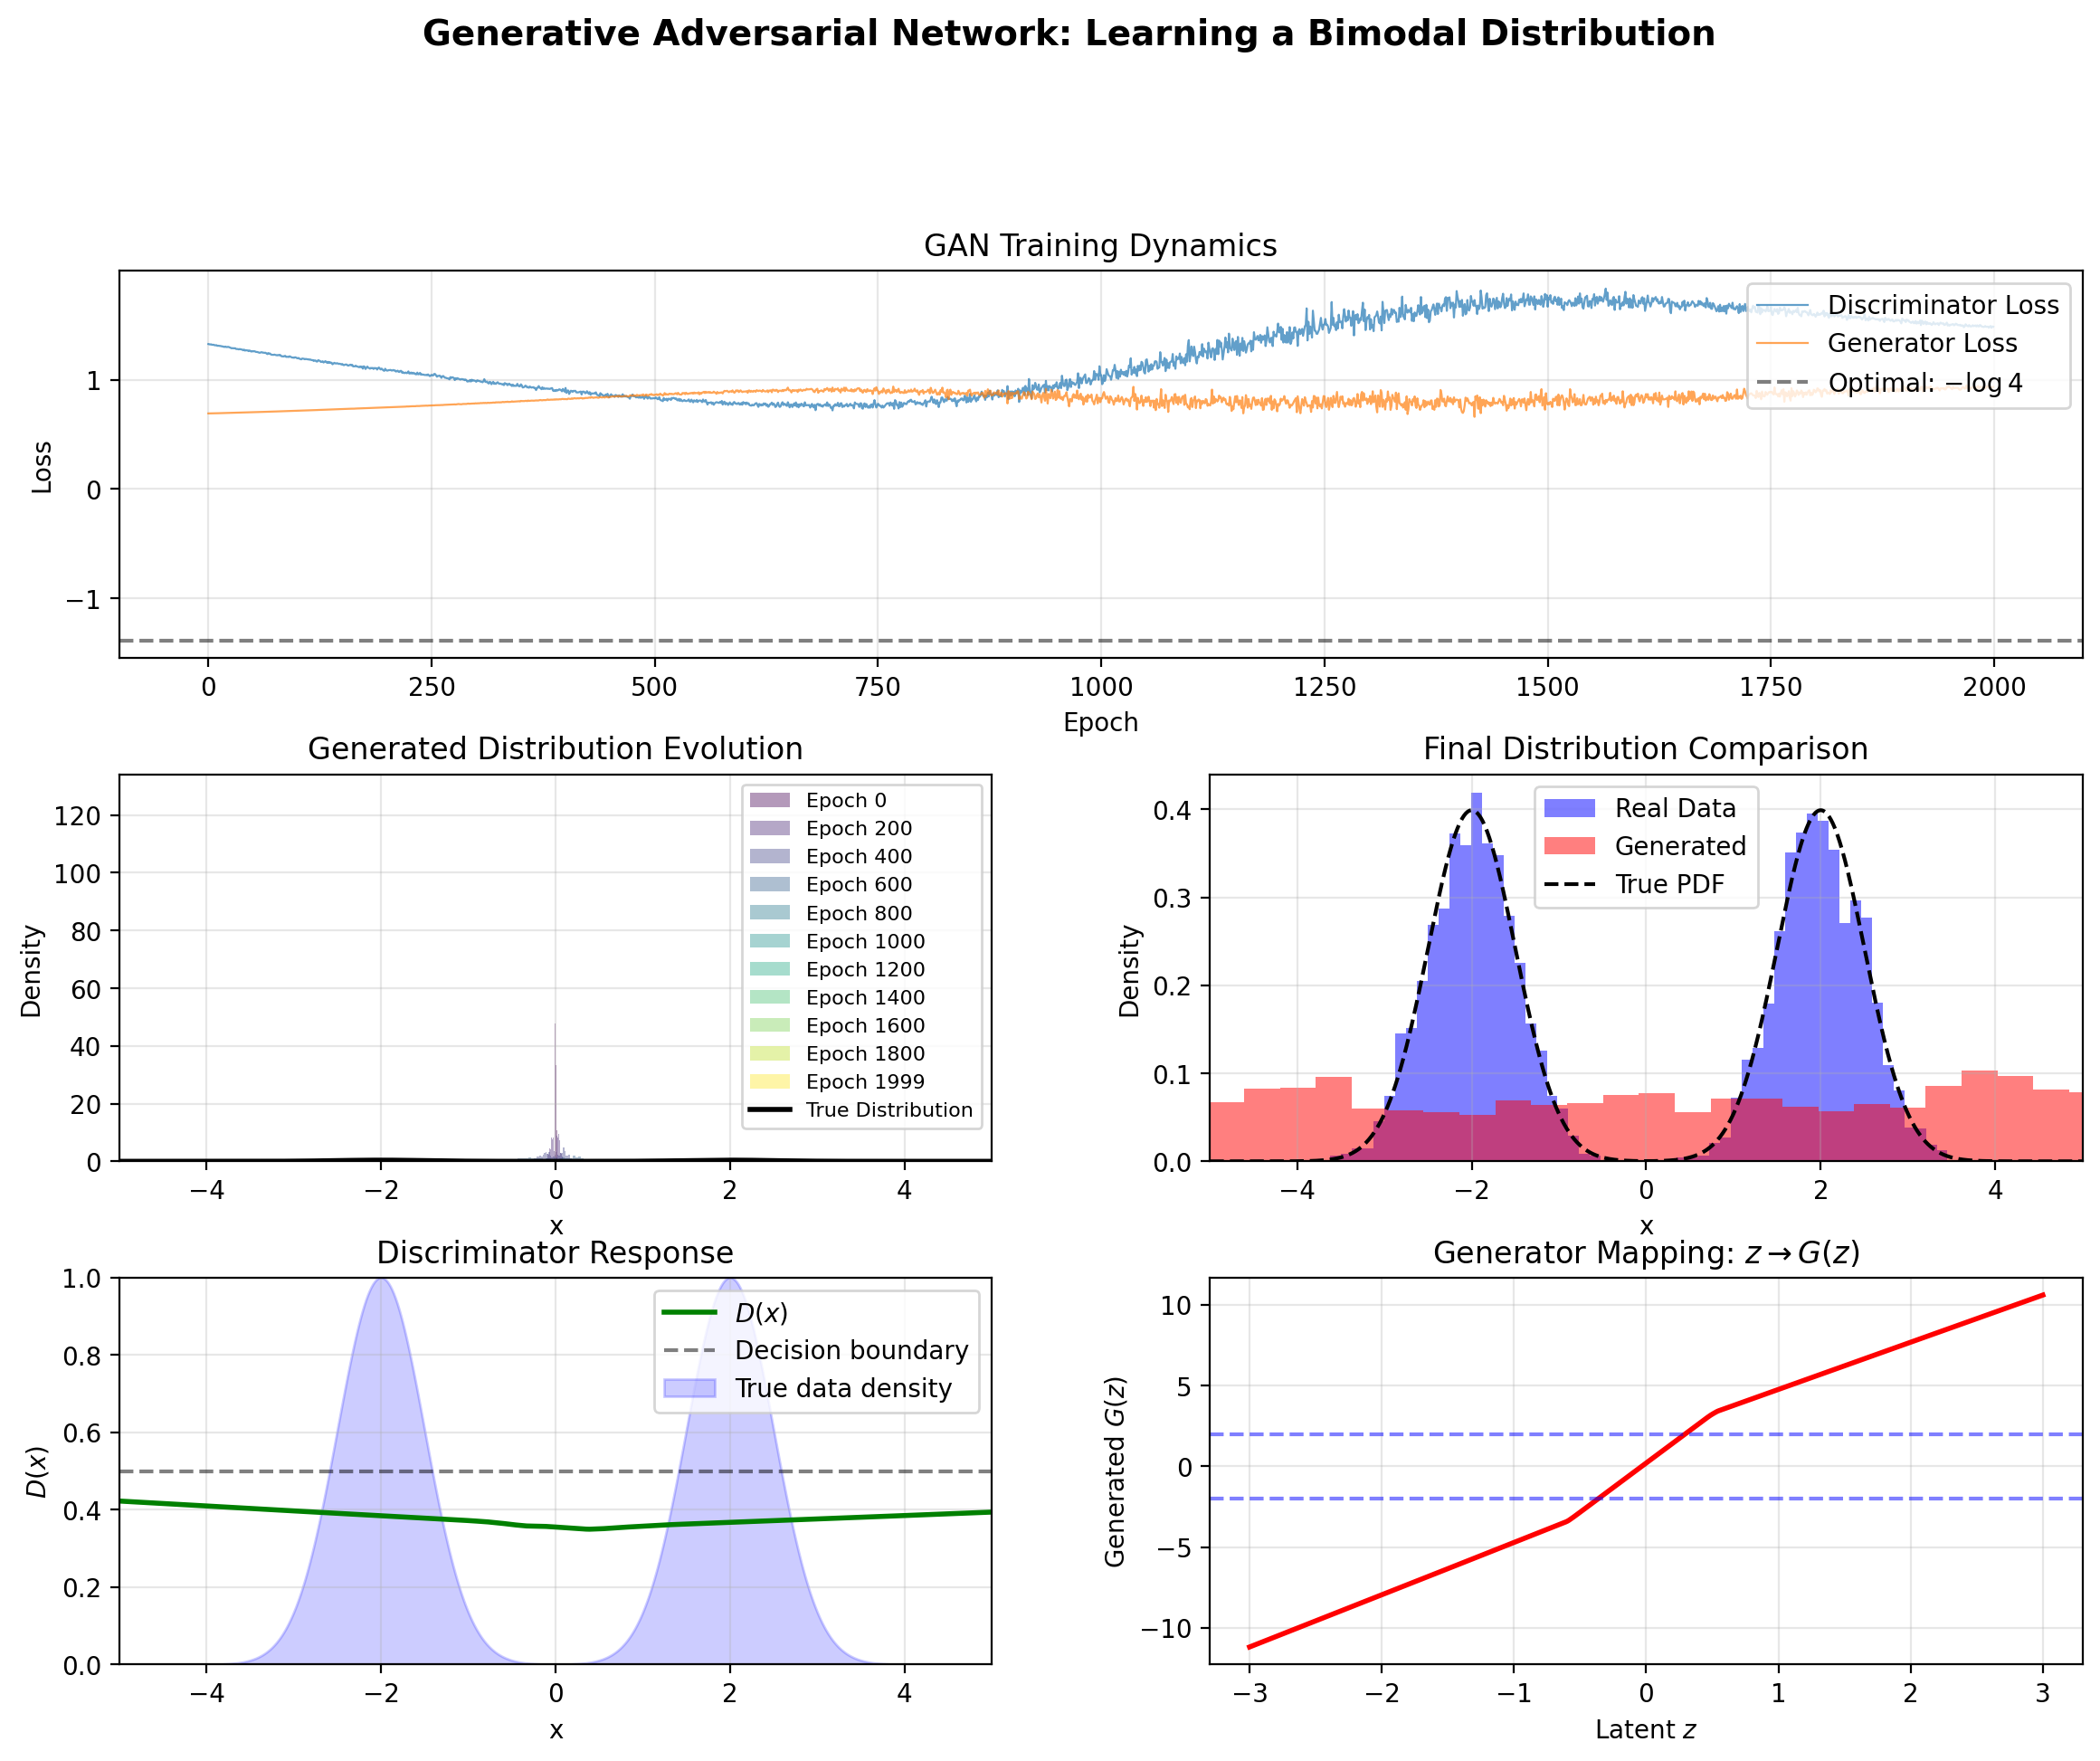


Figure saved to plot.png


In [3]:
# Comprehensive visualization
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)

# Plot 1: Training losses
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(d_losses, label='Discriminator Loss', alpha=0.7, linewidth=0.8)
ax1.plot(g_losses, label='Generator Loss', alpha=0.7, linewidth=0.8)
ax1.axhline(y=-np.log(4), color='k', linestyle='--', label='Optimal: $-\\log 4$', alpha=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('GAN Training Dynamics')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution evolution
ax2 = fig.add_subplot(gs[1, 0])
colors = plt.cm.viridis(np.linspace(0, 1, len(samples_history)))
for i, (epoch, samples) in enumerate(samples_history):
    ax2.hist(samples, bins=50, alpha=0.4, density=True, 
             color=colors[i], label=f'Epoch {epoch}')

# Plot true distribution
x_range = np.linspace(-5, 5, 1000)
true_pdf = 0.5 * (np.exp(-(x_range + 2)**2 / (2 * 0.5**2)) / (0.5 * np.sqrt(2*np.pi)) +
                  np.exp(-(x_range - 2)**2 / (2 * 0.5**2)) / (0.5 * np.sqrt(2*np.pi)))
ax2.plot(x_range, true_pdf, 'k-', linewidth=2, label='True Distribution')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.set_title('Generated Distribution Evolution')
ax2.legend(loc='upper right', fontsize=8)
ax2.set_xlim(-5, 5)
ax2.grid(True, alpha=0.3)

# Plot 3: Final comparison
ax3 = fig.add_subplot(gs[1, 1])
final_samples = gan.generate(5000).flatten()
real_data = generate_real_data(5000).flatten()

ax3.hist(real_data, bins=60, alpha=0.5, density=True, label='Real Data', color='blue')
ax3.hist(final_samples, bins=60, alpha=0.5, density=True, label='Generated', color='red')
ax3.plot(x_range, true_pdf, 'k--', linewidth=1.5, label='True PDF')
ax3.set_xlabel('x')
ax3.set_ylabel('Density')
ax3.set_title('Final Distribution Comparison')
ax3.legend()
ax3.set_xlim(-5, 5)
ax3.grid(True, alpha=0.3)

# Plot 4: Discriminator decision boundary
ax4 = fig.add_subplot(gs[2, 0])
x_test = np.linspace(-5, 5, 500).reshape(-1, 1)
d_scores = gan.discriminator_forward(x_test).flatten()

ax4.plot(x_test, d_scores, 'g-', linewidth=2, label='$D(x)$')
ax4.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision boundary')
# Compute true_pdf for x_test (500 points) to match dimensions
x_test_flat = x_test.flatten()
true_pdf_500 = 0.5 * (np.exp(-(x_test_flat + 2)**2 / (2 * 0.5**2)) / (0.5 * np.sqrt(2*np.pi)) +
                      np.exp(-(x_test_flat - 2)**2 / (2 * 0.5**2)) / (0.5 * np.sqrt(2*np.pi)))
ax4.fill_between(x_test_flat, 0, true_pdf_500/true_pdf_500.max(),
                  alpha=0.2, color='blue', label='True data density')
ax4.set_xlabel('x')
ax4.set_ylabel('$D(x)$')
ax4.set_title('Discriminator Response')
ax4.legend(loc='upper right')
ax4.set_xlim(-5, 5)
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)

# Plot 5: Generator transformation
ax5 = fig.add_subplot(gs[2, 1])
z_samples = np.linspace(-3, 3, 500).reshape(-1, 1)
g_outputs = gan.generator_forward(z_samples).flatten()

ax5.plot(z_samples, g_outputs, 'r-', linewidth=2)
ax5.set_xlabel('Latent $z$')
ax5.set_ylabel('Generated $G(z)$')
ax5.set_title('Generator Mapping: $z \\rightarrow G(z)$')
ax5.grid(True, alpha=0.3)

# Highlight the bimodal output regions
ax5.axhline(y=-2, color='b', linestyle='--', alpha=0.5)
ax5.axhline(y=2, color='b', linestyle='--', alpha=0.5)

plt.suptitle('Generative Adversarial Network: Learning a Bimodal Distribution', 
             fontsize=14, fontweight='bold', y=1.02)

# Save the figure
plt.savefig('gan_basics_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to plot.png")

## Summary

This notebook demonstrated the fundamental concepts of Generative Adversarial Networks:

1. **Theoretical Framework**: GANs formulate generative modeling as a minimax game between generator and discriminator networks.

2. **Training Dynamics**: The adversarial training process alternates between discriminator and generator updates, ideally converging to $p_g = p_{\text{data}}$.

3. **Practical Implementation**: Even a simple two-layer network can learn to generate samples from a multimodal distribution.

4. **Key Observations**:
   - The generator learns to map latent samples to the bimodal target distribution
   - The discriminator converges toward outputting $D(x) \approx 0.5$ when the generator succeeds
   - Training stability requires careful balancing of learning rates and architectures

### Further Reading

- Goodfellow et al. (2014). *Generative Adversarial Nets*. NeurIPS.
- Arjovsky et al. (2017). *Wasserstein GAN*. ICML.
- Gulrajani et al. (2017). *Improved Training of Wasserstein GANs*. NeurIPS.